# Notebook para Treinamento do Random Forest

### Instalação de Requirements

In [ ]:
! pip install -U scikit-learn
! pip install matplotlib
! pip install pyarrow
! pip install fastparquet


## Importação das Bibliotecas Necessárias
Aqui importamos todas as bibliotecas necessárias que serão usadas neste notebook, incluindo o Pandas para manipulação de dados, Random Forest para construir o modelo de classificação, e várias funções do sklearn para avaliação do modelo.

In [20]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

## Carregar e Balancear o Conjunto de Dados
Nós carregamos os dados de um arquivo Parquet. Dado o possível problema de desbalanceamento de classes com a variável 'SUICIDIO', balanceamos o conjunto de dados subamostrando a classe majoritária para igualar a contagem da classe minoritária. Isso ajuda a evitar que o modelo tenha viés em direção à classe majoritária.

In [21]:
df = pd.read_parquet("../data/processed/sim_2006_2017_pre_processed.parquet")

In [63]:
suicidio_0 = df[df['SUICIDIO'] == 0]
suicidio_1 = df[df['SUICIDIO'] == 1]

suicidio_0_sample = suicidio_0.sample(n=len(suicidio_1), replace=False)
balanced_df = pd.concat([suicidio_0_sample, suicidio_1], ignore_index=True).reset_index(drop=True)

## Preparar Dados para Treinamento
Aqui, selecionamos as características e a variável alvo do DataFrame balanceado, seguido pela divisão dos dados em conjuntos de treinamento e teste para avaliar o desempenho do modelo posteriormente.

In [80]:
X = balanced_df[['ESC', 'ESTCIV',     'NATURAL' ,    'OCUP',    'RACACOR'    ,'MASCULINO',    'FEMININO'    ]].values
y = balanced_df['SUICIDIO'].values

### Divisão entre teste e treino

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o Modelo Random Forest

O Random Forest é uma técnica de aprendizado de conjunto (ensemble learning) que constrói múltiplas árvores de decisão durante o treinamento e as combina para obter uma predição mais robusta e geralmente mais precisa.

In [82]:
modelo_rf = RandomForestClassifier(max_depth=2, random_state=0)
modelo_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

### Realizar previsões com o Modelo

In [83]:
y_pred = modelo_rf.predict(X_test)

# Avaliar o Modelo

In [84]:
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.73      0.56      0.63      4745
           1       0.64      0.80      0.71      4688

    accuracy                           0.68      9433
   macro avg       0.69      0.68      0.67      9433
weighted avg       0.69      0.68      0.67      9433

Matriz de Confusão:
 [[2637 2108]
 [ 954 3734]]


# Visualização dos dados

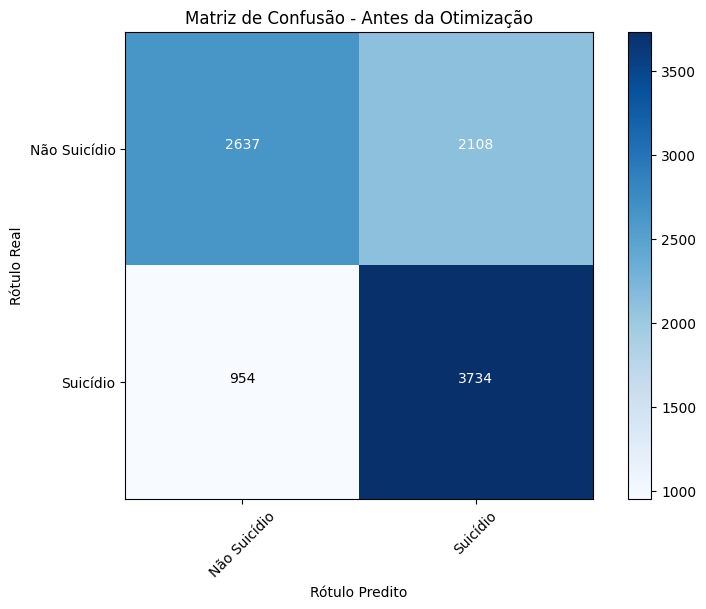

In [85]:
# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Antes da Otimização')
plt.colorbar()
tick_marks = np.arange(len(['Não Suicídio', 'Suicídio']))
plt.xticks(tick_marks, ['Não Suicídio', 'Suicídio'], rotation=45)
plt.yticks(tick_marks, ['Não Suicídio', 'Suicídio'])
plt.tight_layout()
plt.ylabel('Rótulo Real')
plt.xlabel('Rótulo Predito')

# Adicionar os valores nas células da matriz
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()

In [86]:
# Adicionando mais exemplos de teste ao DataFrame
teste = pd.DataFrame({
    'ESC': [5, 5, 4, 4, 3], 
    'ESTCIV': [1, 1, 2, 2, 3], 
    'IDADE': [22, 21, 34, 34, 25], 
    'NATURAL': [53, 52, 29, 29, 35], 
    'OCUP': [-1, -1, 5132, 5132, 1200], 
    'RACACOR': [4, 1, 4, 4, 2], 
    'MASCULINO': [False, True, True, True, False], 
    'FEMININO': [True, False, False, False, True]
})

# Padronizando os dados
columns = ['ESC', 'ESTCIV',  'OCUP', 'RACACOR']
teste[columns] = std.fit_transform(teste[columns])

# Obtendo os valores para previsão
x = teste[['ESC', 'ESTCIV',  'NATURAL', 'OCUP', 'RACACOR', 'MASCULINO', 'FEMININO']].values

# Fazendo previsões
y_pred = modelo_rf.predict(x)
y_pred


array([1, 1, 0, 0, 0], dtype=int64)

# Otimização e ajuste fino do sistema

### Defina a Grade de Parâmetros:
Aqui, usaremos o número de árvores (n_estimators) e a profundidade máxima da árvore (max_depth) como exemplos.

In [87]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}

### Validação Cruzada e Grid Search

Usando a validação cruzada com Grid Search para encontrar a melhor combinação de hiperparâmetros que otimize o desempenho do modelo.

In [88]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=0),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

### Avalie o Melhor Modelo

Após a conclusão do Grid Search, avalie o desempenho do melhor modelo encontrado em um conjunto de dados de teste separado.

Isso irá otimizar e ajustar finamente o sistema Random Forest, encontrando os melhores hiperparâmetros para maximizar o desempenho do modelo. Certifique-se de ajustar os parâmetros conforme necessário e de documentar adequadamente os resultados obtidos

In [89]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Melhores Parâmetros:", grid_search.best_params_)
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))

Melhores Parâmetros: {'max_depth': 10, 'n_estimators': 200}
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.74      0.69      0.71      4745
           1       0.71      0.76      0.73      4688

    accuracy                           0.72      9433
   macro avg       0.72      0.72      0.72      9433
weighted avg       0.72      0.72      0.72      9433

Matriz de Confusão:
 [[3264 1481]
 [1129 3559]]


### Visualização dos Dados 2


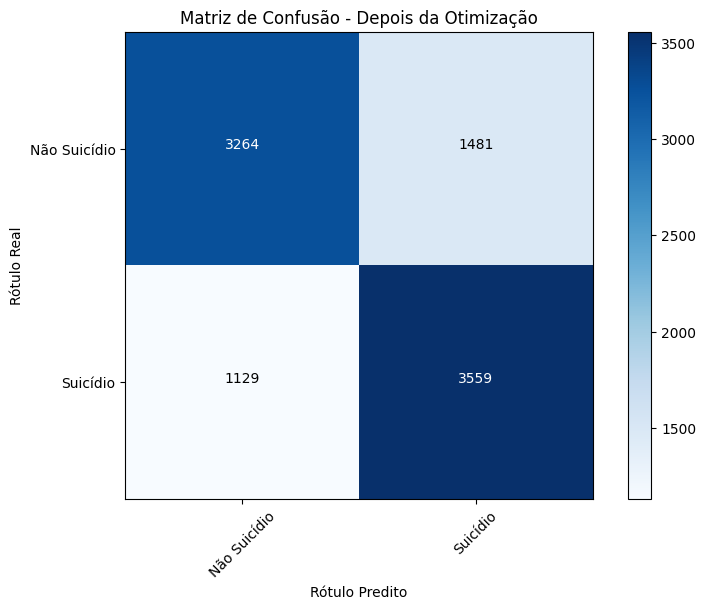

In [90]:
# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Depois da Otimização')
plt.colorbar()
tick_marks = np.arange(len(['Não Suicídio', 'Suicídio']))
plt.xticks(tick_marks, ['Não Suicídio', 'Suicídio'], rotation=45)
plt.yticks(tick_marks, ['Não Suicídio', 'Suicídio'])
plt.tight_layout()
plt.ylabel('Rótulo Real')
plt.xlabel('Rótulo Predito')

# Adicionar os valores nas células da matriz
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()

In [91]:
# Adicionando mais exemplos de teste ao DataFrame
teste = pd.DataFrame({
    'ESC': [5, 5, 4, 4, 3], 
    'ESTCIV': [1, 1, 2, 2, 3], 
    'IDADE': [22, 21, 34, 34, 25], 
    'NATURAL': [53, 52, 29, 29, 35], 
    'OCUP': [-1, -1, 5132, 5132, 1200], 
    'RACACOR': [4, 1, 4, 4, 2], 
    'MASCULINO': [False, True, True, True, False], 
    'FEMININO': [True, False, False, False, True]
})

# Padronizando os dados
columns = ['ESC', 'ESTCIV',  'OCUP', 'RACACOR']
teste[columns] = std.fit_transform(teste[columns])

# Obtendo os valores para previsão
x = teste[['ESC', 'ESTCIV',  'NATURAL', 'OCUP', 'RACACOR', 'MASCULINO', 'FEMININO']].values

# Fazendo previsões
y_pred = best_model.predict(x)
y_pred


array([1, 1, 0, 0, 1], dtype=int64)